In [1]:
from lemaitre import bandpasses

filterlib = bandpasses.get_filterlib()

2025-03-20 14:19:33,171 INFO Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-03-20 14:19:33,171 INFO NumExpr defaulting to 16 threads.
2025-03-20 14:19:33,438 INFO loading lemaitre filterlib from /home/okc/.cache/bbf/lemaitre_flib.default.391295c5c9244927458264594f9bca92b862a8cc8f909d42e0104055288f5979.pkl


In [2]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm.auto import tqdm
import jax.numpy as jnp
import pickle

2025-03-20 14:19:34,542 INFO sparse_dot_mkl found. Building hessian should be faster.
2025-03-20 14:19:34,622 INFO loading lemaitre filterlib from /home/okc/.cache/bbf/lemaitre_flib.default.391295c5c9244927458264594f9bca92b862a8cc8f909d42e0104055288f5979.pkl
INFO:2025-03-20 14:19:36,691:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-03-20 14:19:36,691 INFO Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-03-20 14:19:36,695:jax._src.xla_bridge:945: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-03-20 14:19:36,695 INFO Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [3]:
import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

In [4]:
%matplotlib inline

In [5]:
survey_colors = dict(ZTF="tab:blue", SNLS="tab:orange", HSC="tab:green")

## 2M++ halos loading

When drawing from the 2M++ grid, enforce z_max=0.11677 otherwise it's not anisotrope 

In [6]:
z_max = 0.11677295
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(name="2m++", H0=68.1, Om0=0.306)

##### First loading

In [7]:
import h5py

In [8]:
with h5py.File("./data/hbt_subhalos_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(list(file["Subhalos"]))
    cosmo_params = {
        params: np.array(file["Cosmology"][params])[0]
        for params in list(file["Cosmology"])
    }
    positions = np.array(file["Subhalos"]["ComovingAveragePosition"])
    positions_mostbound = np.array(file["Subhalos"]["ComovingMostBoundPosition"])
    masses = np.array(file["Subhalos"]["BoundM200Crit"])
    velocities = np.array(file["Subhalos"]["PhysicalAverageVelocity"])
    ids = np.array(file["Subhalos"]["HostHaloId"])
    rmax = np.array(file["Subhalos"]["RmaxComoving"])

Keys: <KeysViewHDF5 ['Cosmology', 'Subhalos']>
['BoundM200Crit', 'BoundR200CritComoving', 'ComovingAveragePosition', 'ComovingMostBoundPosition', 'HostHaloId', 'Nbound', 'PhysicalAverageVelocity', 'PhysicalMostBoundVelocity', 'RmaxComoving', 'TrackId', 'VmaxPhysical']


In [10]:
with h5py.File("./data/delta_dm_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    delta = np.array(file["delta_dm"])

with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])

Keys: <KeysViewHDF5 ['Header', 'delta_dm']>
<HDF5 group "/Header" (0 members)>
Keys: <KeysViewHDF5 ['Header', 'velocity_field_0', 'velocity_field_1', 'velocity_field_2', 'velocity_field_radial']>
<HDF5 group "/Header" (0 members)>


In [11]:
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [12]:
halos = pandas.DataFrame(
    {
        "pos_x": positions.T[0] - 500,
        "pos_y": positions.T[1] - 500,
        "pos_z": positions.T[2] - 500,
        "vx": velocities.T[0],
        "vy": velocities.T[1],
        "vz": velocities.T[2],
        "M200c": masses,
        "halo_id": ids,
        "Rmax": rmax,
    }
)


halos["d_c"] = np.sqrt(halos.pos_x**2 + halos.pos_y**2 + halos.pos_z**2)

halos["vpec"] = (
    halos.pos_x * halos.vx + halos.pos_y * halos.vy + halos.pos_z * halos.vz
) / halos.d_c

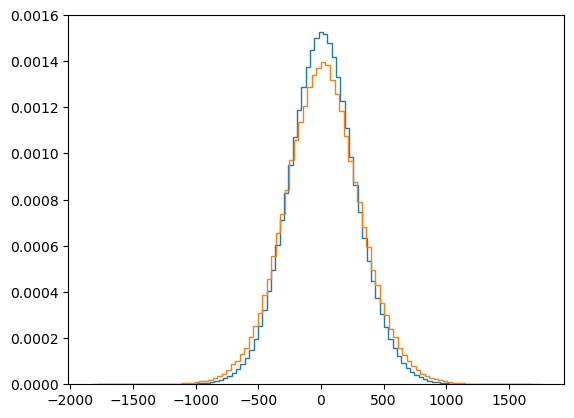

In [13]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step")

In [14]:
from scipy.interpolate import interp1d

dc_to_z = interp1d(
    cosmo.comoving_distance(np.linspace(1e-3, 0.5, 10000)),
    np.linspace(1e-3, 0.5, 10000),
)

In [15]:
halos["z_cosmo"] = dc_to_z(halos.d_c)

In [16]:
halos["z"] = (1 + halos.z_cosmo) * (1 + halos.vpec / c * 1e3) - 1

In [ ]:
from astropy.coordinates import SkyCoord
from astropy.units import Mpc

coords = SkyCoord(
    x=halos.pos_x,
    y=halos.pos_y,
    z=halos.pos_z,
    representation_type="cartesian",
    unit=Mpc,
)

In [18]:
halos["ra"] = coords.icrs.spherical.lon.value
halos.ra -= (halos.ra > 180) * 360
halos["dec"] = coords.icrs.spherical.lat.value

In [19]:
halos.to_csv("data/2M++_subhalo_1.csv")

##### Some plots

In [20]:
halos = pandas.read_csv("data/2M++_subhalo_0.csv")
halos_ = pandas.read_csv("data/2M++_subhalo_1.csv")

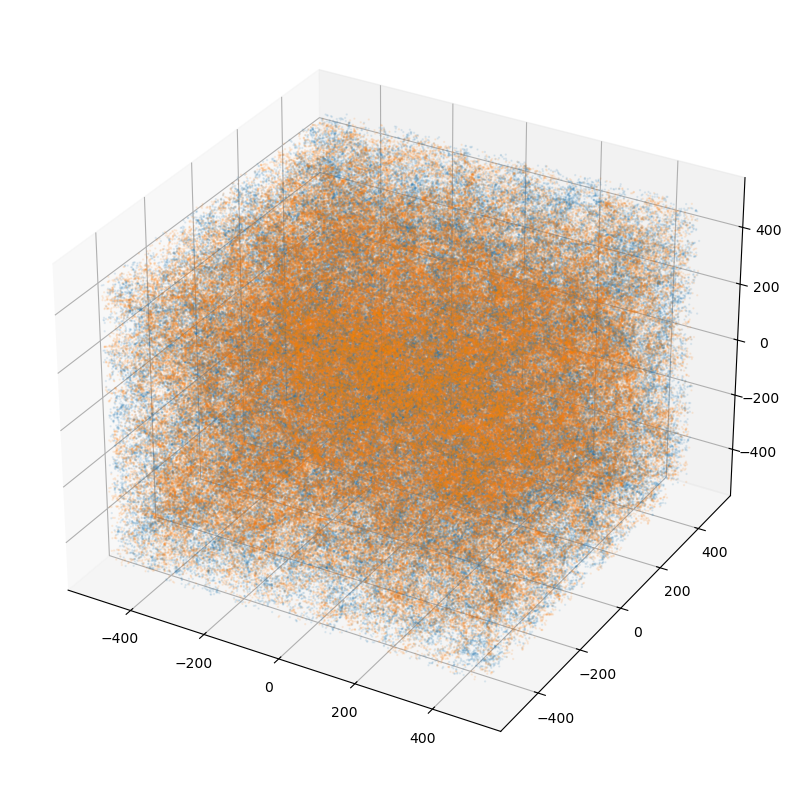

In [21]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)
ax.scatter(halos_.pos_x, halos_.pos_y, halos_.pos_z, s=2, marker=".", alpha=0.1)

In [22]:
one_axis = np.linspace(0, 1000, 256, endpoint=False)
y, x, z = np.meshgrid(one_axis, one_axis, one_axis)
centroids = np.c_[x.ravel(),y.ravel(),z.ravel()] + 1000/512

In [23]:
from scipy.spatial import cKDTree
tree = cKDTree(centroids, boxsize=1000)

In [25]:
dist, id = tree.query(np.c_[halos.pos_x, halos.pos_y, halos.pos_z] + 500)
dist_, id_ = tree.query(np.c_[halos_.pos_x, halos_.pos_y, halos_.pos_z] + 500)

In [ ]:
positions = (centroids - 500)

In [66]:
with h5py.File("./data/velocity_cic_0.hdf5", "r") as file:
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)
with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    vpec_ = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v_ = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [44]:
my_vpec = np.sum(positions[id]*v.reshape(-1, 3)[id], axis=1)/np.sqrt(np.sum(positions[id]**2, axis=1))
my_vpec_ = np.sum(positions[id_]*v_.reshape(-1, 3)[id_], axis=1)/np.sqrt(np.sum(positions[id_]**2, axis=1))

In [45]:
calc_vpec=np.sum(np.multiply(v.reshape(-1, 3)[id], positions[id]), axis=1)/np.linalg.norm(positions[id], ord=2, axis=1)
calc_vpec_=np.sum(np.multiply(v_.reshape(-1, 3)[id_], positions[id_]), axis=1)/np.linalg.norm(positions[id_], ord=2, axis=1)

In [48]:
halos['calc_vpec'] = calc_vpec
halos_['calc_vpec'] = calc_vpec_

In [72]:
halos.columns

Index(['Unnamed: 0', 'pos_x', 'pos_y', 'pos_z', 'vx', 'vy', 'vz', 'M200c',
       'halo_id', 'Rmax', 'd_c', 'vpec', 'z_cosmo', 'z', 'ra', 'dec',
       'calc_vpec'],
      dtype='object')

2025-03-20 16:36:33,013 WARNING Pandas support in corner is deprecated; use ArviZ directly
2025-03-20 16:36:35,899 WARNING Pandas support in corner is deprecated; use ArviZ directly


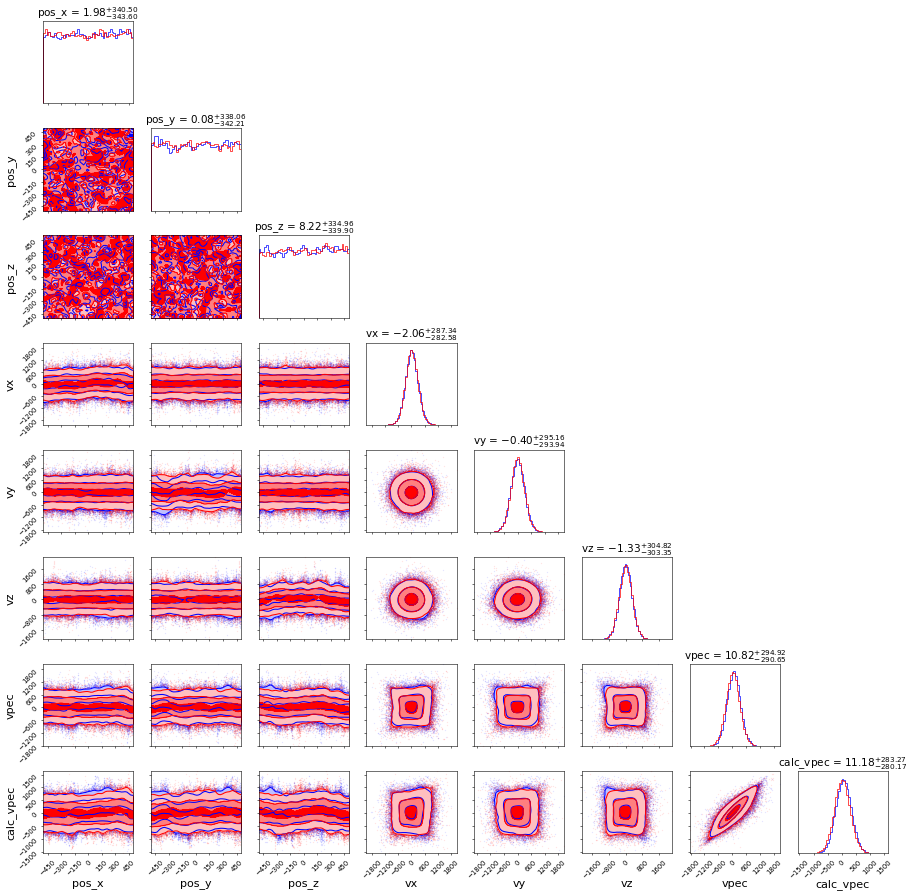

In [74]:
fig = corner_(halos, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], return_fig=True)
corner_(halos_, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], fig=fig, color='r')
plt.tight_layout()

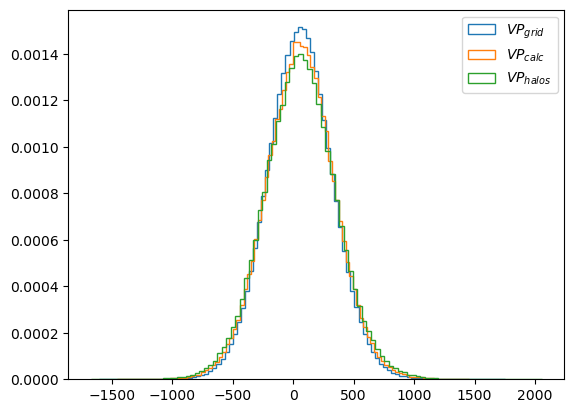

In [67]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


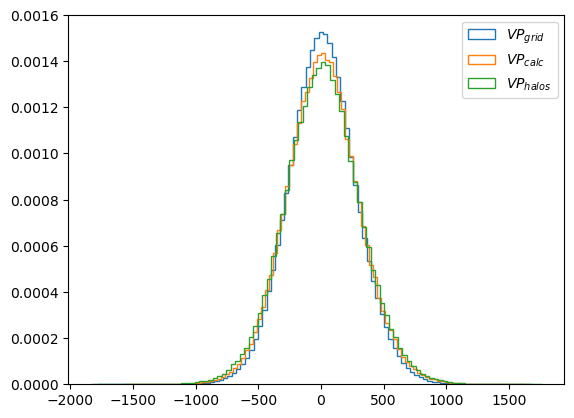

In [68]:
plt.hist(vpec_.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec_, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos_.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


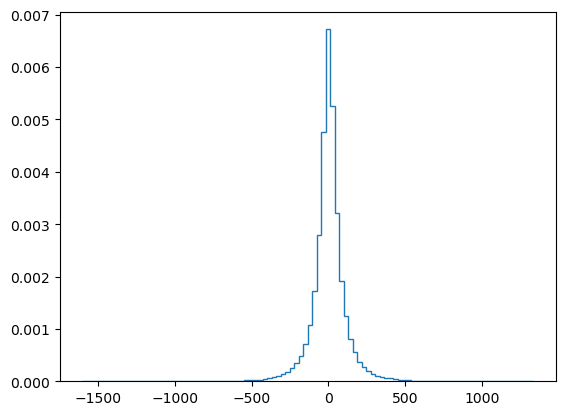

In [52]:
_ = plt.hist(calc_vpec - halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc} - VP_{halos}$")

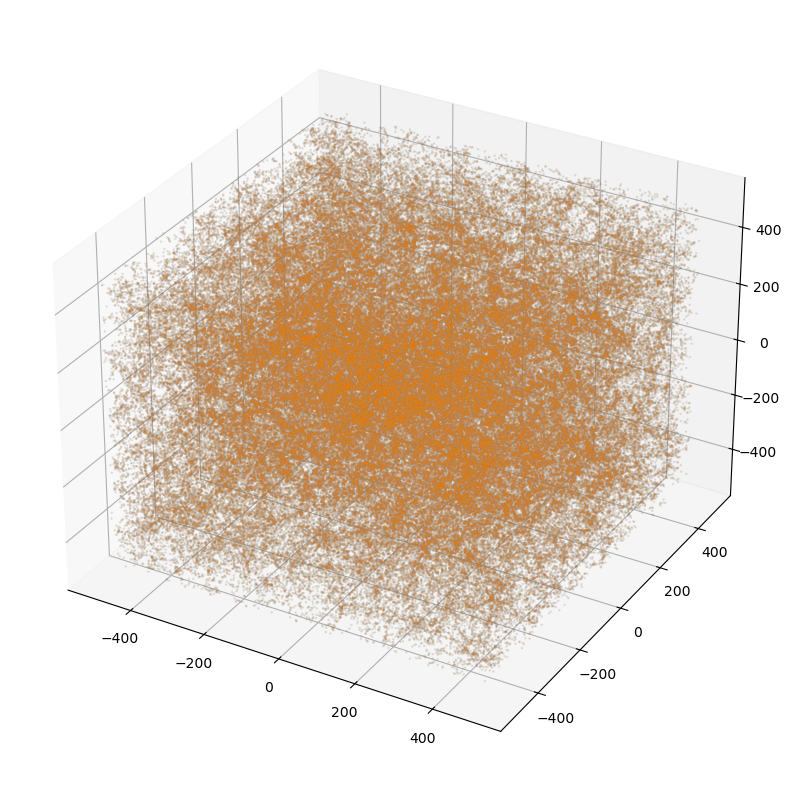

In [18]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(*positions[id].T, s=2, marker=".", alpha=0.1)
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)

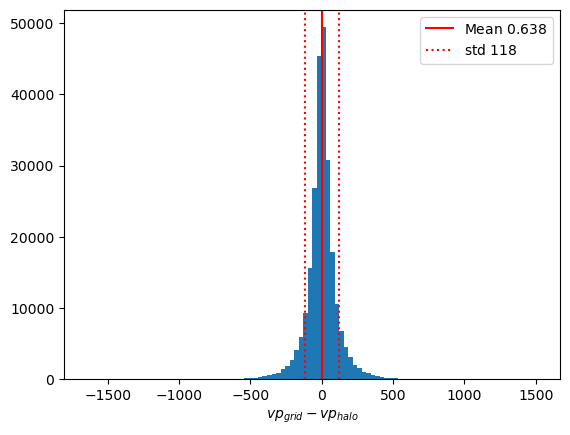

In [56]:
_=plt.hist(vpec.ravel()[id_] - halos_.vpec, bins=100)
mean, std = (vpec.ravel()[id_] - halos_.vpec).mean(), (vpec.ravel()[id_] - halos_.vpec).std()
plt.axvline(mean, color="r", label=rf'Mean ${mean:.3g}$')
plt.axvline(mean + std, color="r", linestyle=':', label=rf'std ${std:.3g}$')
plt.axvline(mean - std, color="r", linestyle=':')
plt.xlabel(r"$vp_{grid} - vp_{halo}$")
plt.legend()

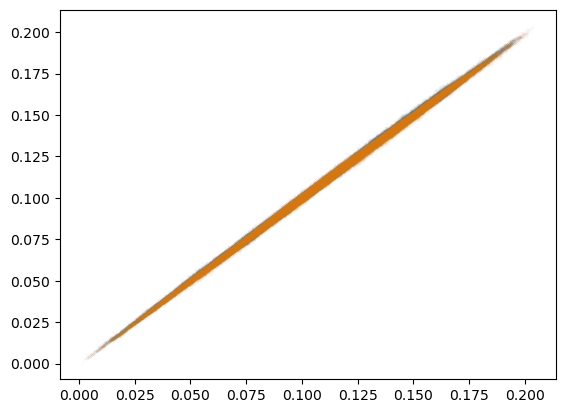

In [61]:
plt.scatter(halos.z_cosmo, halos.z, marker=".", s=0.1, alpha=0.1)
plt.scatter(halos_.z_cosmo, halos_.z, marker=".", s=0.1, alpha=0.1)

Text(0, 0.5, 'vpec')

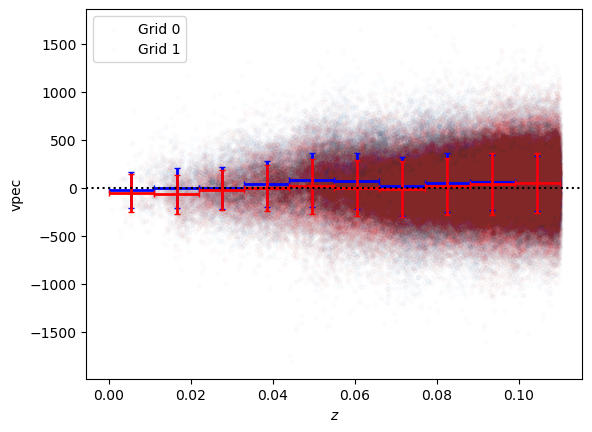

In [76]:
z_max = 0.11
n_bins = 10
width = z_max / n_bins
bounds = np.linspace(0, z_max - width, n_bins)

in_bins = [(halos.z > d_min) & (halos.z < d_min + width) for d_min in bounds]
in_bins_ = [(halos_.z > d_min) & (halos_.z < d_min + width) for d_min in bounds]
plt.scatter(
    halos.z[halos.z < z_max],
    halos.vpec[halos.z < z_max],
    marker=".",
    alpha=0.01,
    label="Grid 0",
)

plt.scatter(
    halos_.z[halos_.z < z_max],
    halos_.vpec[halos_.z < z_max],
    marker=".",
    color="tab:red",
    alpha=0.01,
    label="Grid 1",
)

plt.errorbar(
    bounds + width / 2,
    [halos.vpec[filt].mean() for filt in in_bins],
    yerr=[halos.vpec[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.errorbar(
    bounds + width / 2,
    [halos_.vpec[filt].mean() for filt in in_bins_],
    yerr=[halos_.vpec[filt].std() for filt in in_bins_],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.axhline(0, color="k", linestyle=":")
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'vpec')


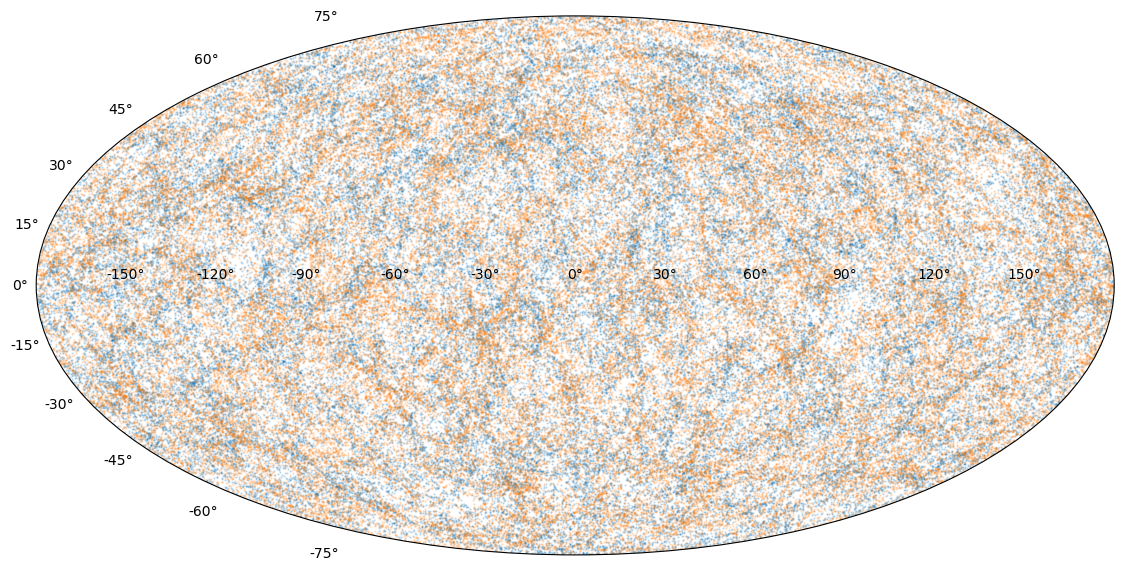

In [65]:
fig, ax = plt.subplots(figsize=(20, 7), subplot_kw=dict(projection="mollweide"))
ax.scatter(
    halos.ra[halos.z_cosmo < 0.1] * np.pi / 180,
    halos.dec[halos.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)
ax.scatter(
    halos_.ra[halos_.z_cosmo < 0.1] * np.pi / 180,
    halos_.dec[halos_.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)

## SNe Generation from 2M++

### ZTF

In [7]:
with open("./data/dataset_2M++.pkl", "rb") as file:
    data = pickle.load(file)
    lc = pickle.load(file)

2025-02-28 16:18:48,838 WARNING Pandas support in corner is deprecated; use ArviZ directly


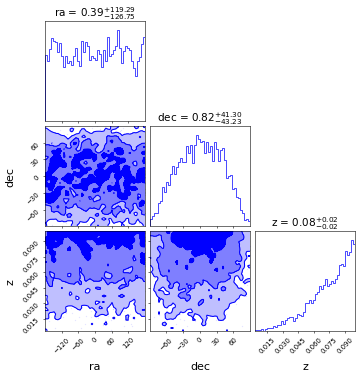

In [9]:
corner_(data, var_names=['ra', 'dec', 'z'])

2025-02-28 13:36:49,209 WARNING Pandas support in corner is deprecated; use ArviZ directly


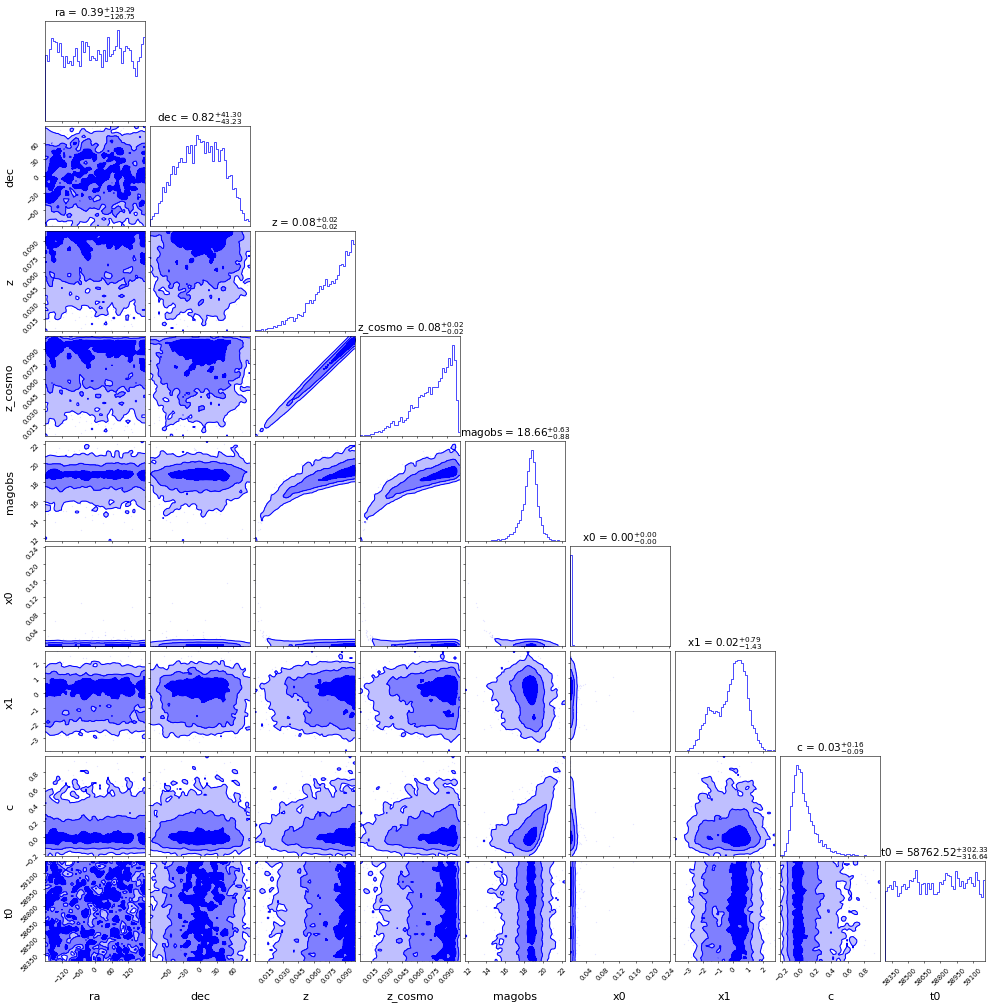

In [9]:
_ = corner_(
    data,
    var_names=["ra", "dec", "z", "z_cosmo", "magobs", "x0", "x1", "c", "t0"],
)

### Simple SALT fit after pets `make_sample.py`

In [ ]:
data_snls, lc_snls = load_from_skysurvey('data/dataset_snls.pkl', 'SNLS')
data_ztf, lc_ztf = load_from_skysurvey('data/dataset_2M++.pkl', 'ZTF')
data_hsc, lc_hsc = load_from_skysurvey('data/dataset_hsc.pkl', 'HSC')

In [ ]:
data = pandas.concat([data_ztf, data_snls, data_hsc])
lc = pandas.concat([lc_ztf, lc_snls, lc_hsc])

In [ ]:
data_ztf_pets, lc_ztf_pets = load_from_pets('data/pets_2M++/', 'ZTF')
data_snls_pets, lc_snls_pets = load_from_pets('data/pets_snls/', 'SNLS')
data_hsc_pets, lc_hsc_pets = load_from_pets('data/pets_hsc/', 'HSC')

In [ ]:
data_pets = pandas.concat([data_ztf_pets, data_snls_pets, data_hsc_pets])
lc_pets = pandas.concat([lc_ztf_pets, lc_snls_pets, lc_hsc_pets])

In [ ]:
data.valid=data_pets.valid

In [ ]:
from astropy.table import Table

source = sncosmo.SALT2Source(
    modeldir="data/SALT_snf/",
    m0file="nacl_m0_test.dat",
    m1file="nacl_m1_test.dat",
    clfile="nacl_color_law_test.dat",
)
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(
    source=source, effects=[dust], effect_names=["mw"], effect_frames=["obs"]
)

In [ ]:
data_pets["magobs"] = -2.5 * np.log10(data_pets.x0) + model.source.peakmag(
    "bessellb", "ab"
)

/home/okc/anaconda3/envs/lemaitre/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]

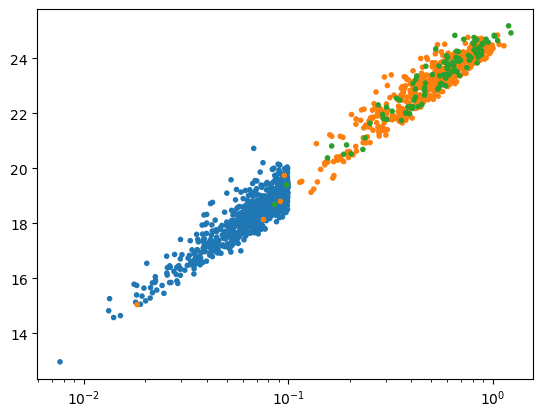

In [ ]:
plt.scatter(
    data[data.valid].z,
    data[data.valid].magobs,
    c=[survey_colors[s] for s in data[data.valid].survey],
    marker=".",
)
# plt.scatter(data_pets.zhel,
#             data_pets.magobs,
#             c=[survey_colors[s] for s in data.survey],
#             marker='.')
plt.semilogx()

In [ ]:
def fit_sn(model, sn, lc, data, modelcov=True):
    from iminuit.warnings import IMinuitWarning
    import warnings
    warnings.filterwarnings("ignore", category=IMinuitWarning)
    try:
        lc_sn = lc.loc[sn]
        lc_sncosmo=Table.from_pandas(lc_sn[['time','flux','fluxerr','zpsys','band','zp']])

        model.set(z=data.loc[sn, "z"],
                  mwebv=data.loc[sn, 'mwebv'], mwr_v=3.1)  # set the model's redshift and MW
        t0=data.loc[sn, 't0']
        res, _ = sncosmo.fit_lc(lc_sncosmo, model,['t0', 'x0', 'x1', 'c'],
                                bounds={'x0':(-0.1,10),'x1':(-5, 5),'c':(-3, 3), 't0':(t0-3, t0+3)}, phase_range=None, modelcov=modelcov)
        return res
    except:
        return None



In [ ]:
lc = lc[(lc.flux/lc.fluxerr>5)].copy()

In [ ]:
_at_least_n_bands = lc.groupby(level=0).band.nunique() >= 2
_at_least_n_points = lc.time.between(data.loc[lc.name, 't0'] - 50, data.loc[lc.name, 't0'] + 100).groupby(level=0).count() >= 5
_at_least_n_points_before = lc.time.between(data.loc[lc.name, 't0'] - 50, data.loc[lc.name, 't0']).groupby(level=0).count() >= 2
_at_least_n_points_after = lc.time.between(data.loc[lc.name, 't0'], data.loc[lc.name, 't0'] + 100).groupby(level=0).count() >= 2
_c_range = data[data.name.isin(lc.name)].c.between(-0.2, 0.8)
_x1_range = data[data.name.isin(lc.name)].x1.between(-3, 3)

In [ ]:
all_conds = _at_least_n_bands & _at_least_n_points & _at_least_n_points_before & _at_least_n_points_after & _c_range & _x1_range

In [ ]:
print(f"With 2 bands \t\t {np.sum(_at_least_n_bands)}")
print(f"With 5 points \t\t {np.sum(_at_least_n_points)}")
print(f"With 2 points before \t {np.sum(_at_least_n_points_before)}")
print(f"With 2 points after \t {np.sum(_at_least_n_points_after)}")
print(f"With c in [-0.2, 0.8] \t {np.sum(_c_range)}")
print(f"With x1 in [-3, 3] \t {np.sum(_x1_range)}")
print(f"All conditions \t {np.sum(all_conds)}")


With 2 bands 		 3407
With 5 points 		 3155
With 2 points before 	 4275
With 2 points after 	 4275
With c in [-0.2, 0.8] 	 5093
With x1 in [-3, 3] 	 5092
All conditions 	 2863


In [ ]:
data.valid = False
data.loc[all_conds.index, 'valid'] = all_conds

In [ ]:
data.loc[sn, "t0"]

59055.96875

In [ ]:
results = [fit_sn(model, sn, lc, data) for sn in tqdm(data[data.valid].name)]

  0%|          | 0/2863 [00:00<?, ?it/s]

In [ ]:
with open("outdir/ztf_2M++_snls_hsc_raw_DR2cuts.pkl", "wb") as file:
    pickle.dump(results, file)

In [ ]:
values = pandas.DataFrame(
    [res.parameters[[0, 1, 2, 3, 4]] for res in results],
    columns=["z", "t0", "x0", "x1", "c"],
    index=data[data.valid].name,
)

In [ ]:
covs = {
    sn: res.covariance
    for res, sn in zip(results, data[data.valid].name)
}

In [ ]:
with open("outdir/ztf_2M++_snls_hsc_DR2cuts.pkl", "wb") as file:
    pickle.dump(values, file)
    pickle.dump(covs, file)

In [ ]:
data.loc[data.valid, 'valid'] = [res.success for res in results]

In [ ]:
with open("outdir/ztf_2M++_snls_hsc_DR2cuts.pkl", "rb") as file:
    values = pickle.load(file)
    covs = pickle.load(file)

In [ ]:
new_covs = {
    i: jnp.matmul(
        jnp.matmul(
            jnp.array(
                [
                    [-2.5 / (np.log(10) * values.loc[i, "x0"]), 0, 0],
                    [0, 1, 0],
                    [0, 0, 1],
                ]
            ),
            covs[i][1:, 1:],
        ),
        jnp.array(
            [
                [-2.5 / (np.log(10) * values.loc[i, "x0"]), 0, 0],
                [0, 1, 0],
                [0, 0, 1],
            ]
        ),
    )
    for i in data[data.valid].name
}

In [ ]:
values["magobs"] = -2.5 * np.log10(values["x0"]) + model.source.peakmag(
    "bessellb", "ab"
)

values["valid"] = data.valid

In [ ]:
values["err_t0"] = [np.sqrt(covs[i][0, 0]) for i in values.index]
values["err_x0"] = [np.sqrt(covs[i][1, 1]) for i in values.index]
values["err_x1"] = [np.sqrt(covs[i][2, 2]) for i in values.index]
values["err_c"] = [np.sqrt(covs[i][3, 3]) for i in values.index]
values["err_magobs"] = [np.sqrt(new_covs[i][0, 0]) for i in values.index]

In [ ]:
values.valid &= (
    (np.abs(values.x1) < 3)
    & (values.err_x1 < 1)
    & (values.err_c < 0.1)
)

In [ ]:
values["mu"] = values.magobs + 0.14 * values.x1 - 3.15 * values.c
data["mu"] = (
    data.magobs + 0.14 * data.x1 - 3.15 * data.c
)

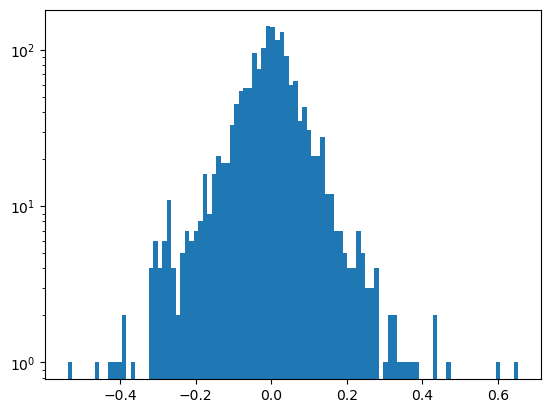

In [ ]:
_ = plt.hist(
    data["mu"][data.valid][values.valid] - values["mu"][values.valid], bins=100, log=True
)

2025-02-20 16:45:40,891 WARNING Pandas support in corner is deprecated; use ArviZ directly


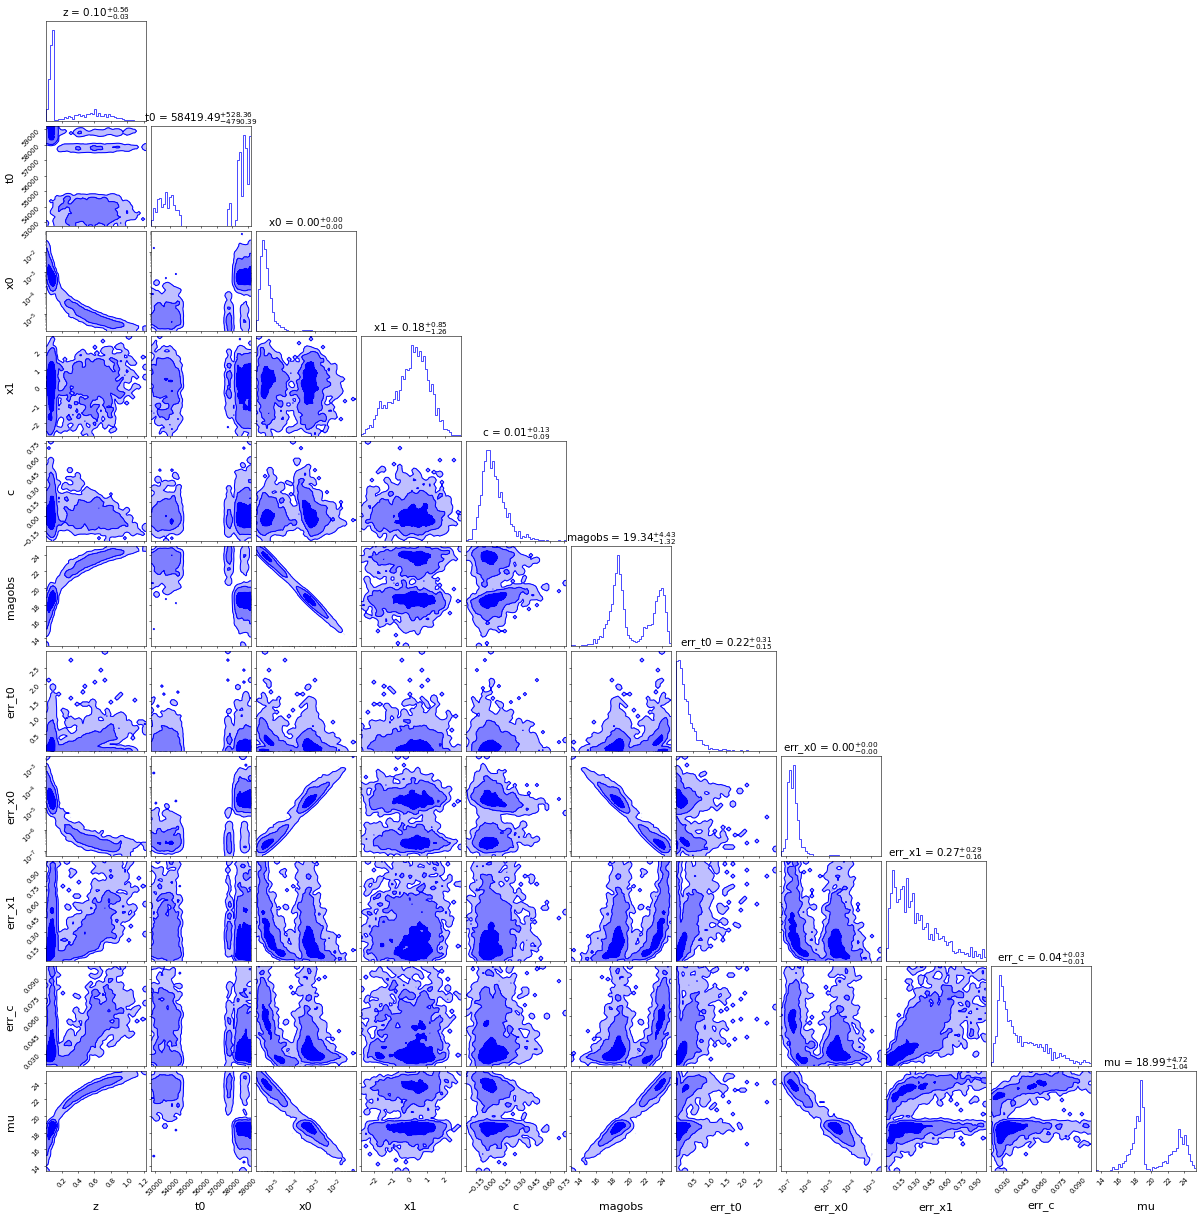

In [ ]:
_ = corner_(
    values[values.valid],
    var_names=[
        "z",
        "t0",
        "x0",
        "x1",
        "c",
        "magobs",
        "err_t0",
        "err_x0",
        "err_x1",
        "err_c",
        "mu",
    ],
    axes_scale=[
        "linear",
        "linear",
        "log",
        "linear",
        "linear",
        "linear",
        "linear",
        "log",
        "linear",
        "linear",
        "linear",
    ],
)

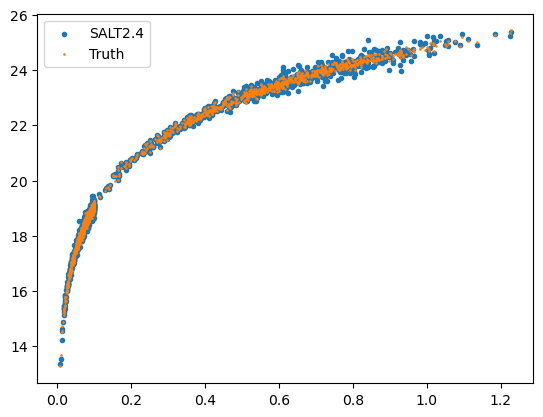

In [ ]:
plt.scatter(
    values[values.valid].z,
    values[values.valid].magobs
    + 0.14 * values[values.valid].x1
    - 3.15 * values[values.valid].c,
    marker=".",
    label="SALT2.4",
)
plt.scatter(
    data[data.valid][values.valid].z,
    data[data.valid][values.valid].magobs
    + 0.14 * data[data.valid][values.valid].x1
    - 3.15 * data[data.valid][values.valid].c,
    s=3,
    marker=".",
    label="Truth",
)
plt.legend()

In [ ]:
def plot_lc_index(index, lc_data, sne_data=None):
    """
    My plotting for lightcurve because I was tired of having to put everything in a skysurvey dataset.
    """
    if sne_data is not None:
        model.set(z=sne_data.loc[index, 'z'],
                  x0=sne_data.loc[index, 'x0'],
                  x1=sne_data.loc[index, 'x1'],
                  c=sne_data.loc[index, 'c'],
                  mwebv=sne_data.loc[index, 'mwebv'],
                  mwr_v=3.1,t0=0)  # set the model's redshift and MW

        if "tmax" in sne_data.columns:
            t0 = sne_data.loc[index, "tmax"]
            err_t0 = sne_data.loc[index, "err_tmax"]
            plt.axvline(t0, color="r", label=r"$t_0$")
            plt.axvline(t0 - err_t0, color="r", linestyle=":")
            plt.axvline(t0 + err_t0, color="r", linestyle=":")
        else:
            t0 = sne_data.loc[index, "t0"]
            plt.axvline(t0, color="r", label=r"$t_0$")

    for b in np.unique(lc_data[(lc_data.name==index) & (lc_data.valid==1)].band):
        lc = lc_data[(lc_data.band==b) & (lc_data.name==index)].sort_values(by='mjd')
        coef = 10 ** (-(lc["zp"] - 25) / 2.5)
        plt.errorbar(lc["mjd"],
                     lc["flux"]*coef,
                     yerr=lc["fluxerr"]*coef,
                     linestyle='',
                     marker='.',
                     color=color_band[b],
                     label=b
                    )
        if sne_data is not None:
            times = np.linspace(-20, 50, 1000)
            plt.plot(times+t0, model.bandflux(b, times, zp=25, zpsys="AB"), color=color_band[b])

        
    plt.title(f"SN {index}")
    plt.legend()



In [ ]:
def mag_cosmo(z):
    return jnp.array(cosmo.distmod(z).value - 19.3)

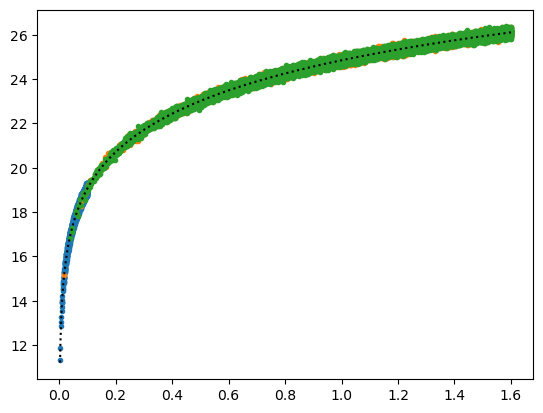

In [ ]:
plt.scatter(
    data[data.survey == "ZTF"].z,
    data[data.survey == "ZTF"].magobs
    + 0.14 * data[data.survey == "ZTF"].x1
    - 3.15 * data[data.survey == "ZTF"].c,
    marker=".",
    label="ZTF",
)
plt.scatter(
    data[data.survey == "SNLS"].z,
    data[data.survey == "SNLS"].magobs
    + 0.14 * data[data.survey == "SNLS"].x1
    - 3.15 * data[data.survey == "SNLS"].c,
    marker=".",
    label="SNLS",
)
plt.scatter(
    data[data.survey == "HSC"].z,
    data[data.survey == "HSC"].magobs
    + 0.14 * data[data.survey == "HSC"].x1
    - 3.15 * data[data.survey == "HSC"].c,
    marker=".",
    label="HSC",
)
plt.plot(
    np.linspace(data.z.min(), data.z.max(), 1000),
    mag_cosmo(np.linspace(data.z.min(), data.z.max(), 1000)),
    linestyle=":",
    color="k",
)

In [ ]:
mag_to_z = interp1d(
    mag_cosmo(np.linspace(1e-5, 0.5, 10000)), np.linspace(1e-5, 0.5, 10000)
)

In [ ]:
data_pets["err_magobs"] = (
    2.5 * data_pets.err_x0 / (np.log(10) * data_pets.x0)
)

In [ ]:
mu_covs = {
    i: jnp.matmul(
        jnp.matmul(
            jnp.array(
                [
                    [1, 0.14, -3.15],
                    [0, 1, 0],
                    [0, 0, 1],
                ]
            ),
            new_covs[i],
        ),
        jnp.array(
            [
                [1, 0, 0],
                [0.14, 1, 0],
                [-3.15, 0, 1],
            ]
        ),
    )
    for i in values.index
}
values["mu"] = values.magobs + 0.14 * values.x1 - 3.15 * values.c
values["err_mu"] = jnp.sqrt(np.array([mu_covs[i][0, 0] for i in values.index]))

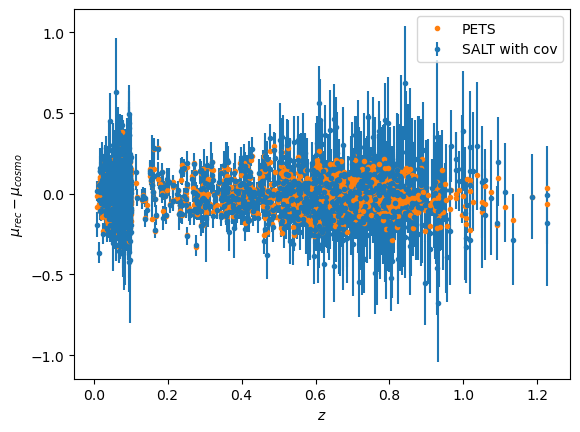

In [ ]:
plt.errorbar(
    values[values.valid].z,
    values[values.valid].mu - mag_cosmo(values[values.valid].z),
    values[values.valid].err_mu,
    linestyle="",
    marker=".",
    label="SALT with cov",
)

plt.plot(data[data.valid][values.valid].z,
            data[data.valid][values.valid].mu - mag_cosmo(data[data.valid].z[values.valid]),
            linestyle='',
            marker='.',
            label='PETS',
            color="tab:orange")

# plt.ylim(-3,3)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu_{rec} - \mu_{cosmo}$")
plt.legend()

In [ ]:
use_vpec = data[data.valid].survey == "ZTF"
z_cosmo_pets = mag_to_z(values[use_vpec].mu)

In [ ]:
errp_z_cosmo_pets = (
    mag_to_z(values[use_vpec].mu + values[use_vpec].err_mu) - z_cosmo_pets
)
errm_z_cosmo_pets = z_cosmo_pets - mag_to_z(
    values[use_vpec].mu - values[use_vpec].err_mu
)

In [ ]:
z_cosmo = mag_to_z(
    data[data.survey == "ZTF"].magobs
    + 0.14 * data[data.survey == "ZTF"].x1
    - 3.15 * data[data.survey == "ZTF"].c
)

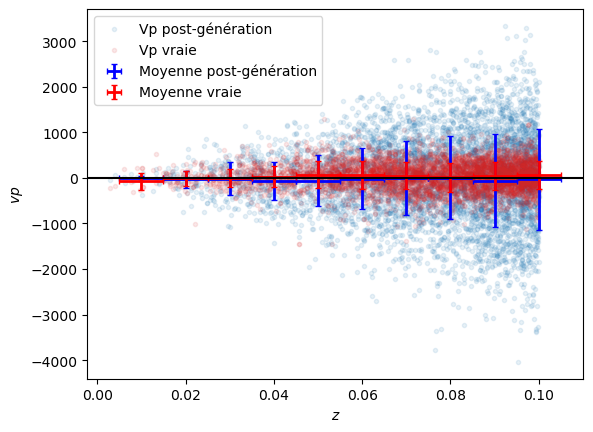

In [ ]:
data_ztf = data[data.survey == "ZTF"]
pv = (data_ztf.z - z_cosmo) * c * 1e-3 / (1 + z_cosmo)
true_pv = (data_ztf.z - data_ztf.z_cosmo) * c * 1e-3 / (1 + data_ztf.z_cosmo)

z_max = 0.2
n_bins = 20
bounds = np.linspace(0.00, z_max, n_bins + 1)
width = z_max / n_bins
in_bins = [(data_ztf.z > z_min) & (data_ztf.z < z_min + width) for z_min in bounds]

plt.scatter(data_ztf.z, pv, marker=".", alpha=0.1, label="Vp post-génération")
plt.scatter(
    data_ztf.z, true_pv, marker=".", color="tab:red", alpha=0.1, label="Vp vraie"
)

plt.errorbar(
    bounds + width,
    [pv[filt].mean() for filt in in_bins],
    yerr=[pv[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="Moyenne post-génération",
)

plt.errorbar(
    bounds + width,
    [true_pv[filt].mean() for filt in in_bins],
    yerr=[true_pv[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    capsize=2,
    label="Moyenne vraie",
)

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color="k")

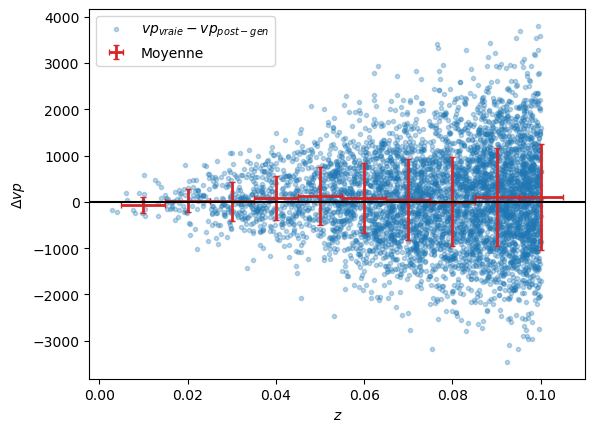

In [ ]:
plt.scatter(
    data_ztf.z,
    true_pv - pv,
    marker=".",
    alpha=0.3,
    label="$vp_{vraie} - vp_{post-gen}$",
)

plt.errorbar(
    bounds + width,
    [(true_pv - pv)[filt].mean() for filt in in_bins],
    yerr=[(true_pv - pv)[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="tab:red",
    linewidth=2,
    capsize=2,
    label="Moyenne",
)

plt.xlabel("$z$")
plt.ylabel(r"$\Delta vp$")
plt.legend()

plt.axhline(0, color="k")

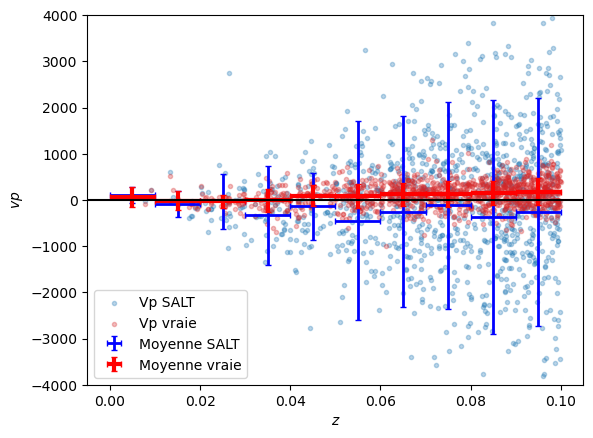

In [ ]:
z_max = 0.2
n_bins = 20
bounds = np.linspace(0.00, z_max, n_bins + 1)
width = z_max / n_bins

data_used = data[data.valid][use_vpec]

in_bins = [(data_used.z > z_min) & (data_used.z < z_min + width) for z_min in bounds]

pets_pv = (
    (data_used.z - z_cosmo_pets)
    * c
    * 1e-3
    / (1 + z_cosmo_pets[values[use_vpec].z < 0.1])
)
true_pv = (data_used.z - data_used.z_cosmo) * c * 1e-3 / (1 + data_used.z_cosmo)

plt.scatter(data_used.z, pets_pv, marker=".", alpha=0.3, label="Vp SALT")
plt.scatter(
    data_used.z, true_pv, marker=".", color="tab:red", alpha=0.3, label="Vp vraie"
)

plt.errorbar(
    bounds + width / 2,
    [pets_pv[filt].mean() for filt in in_bins],
    yerr=[pets_pv[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="Moyenne SALT",
)

plt.errorbar(
    bounds + width / 2,
    [true_pv[filt].mean() for filt in in_bins],
    yerr=[true_pv[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=3,
    capsize=2,
    label="Moyenne vraie",
)


plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.ylim(-4000, 4000)
plt.axhline(0, color="k")

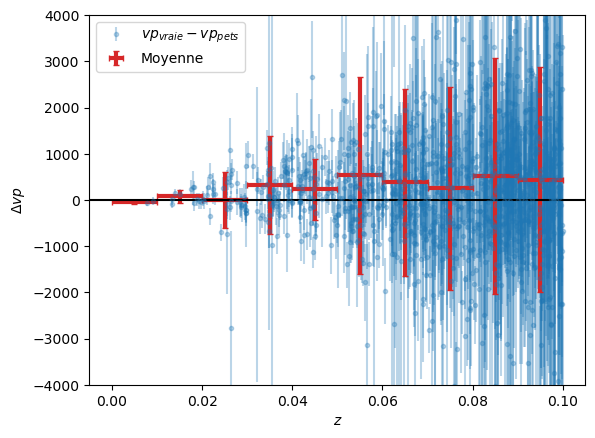

In [ ]:
plt.errorbar(
    data_used.z,
    true_pv - pets_pv,
    np.array(
        [
            errp_z_cosmo_pets[values[use_vpec].z < 0.1],
            errm_z_cosmo_pets[values[use_vpec].z < 0.1],
        ]
    )
    * c.value
    * 1e-3,
    marker=".",
    linestyle="",
    alpha=0.3,
    label="$vp_{vraie} - vp_{pets}$",
)
plt.errorbar(
    bounds + width / 2,
    [(true_pv - pets_pv)[filt].mean() for filt in in_bins],
    yerr=[(true_pv - pets_pv)[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="tab:red",
    linewidth=3,
    capsize=2,
    label="Moyenne",
)

plt.xlabel("$z$")
plt.ylabel(r"$\Delta vp$")
plt.legend()
plt.ylim(-4000, 4000)
plt.axhline(0, color="k")

In [ ]:
np.mean(true_pv - pets_pv), np.std(true_pv - pets_pv)

(388.63593780191866, 2157.8052684931736)

In [ ]:
filt= values.valid
valid_data = data[data.valid]

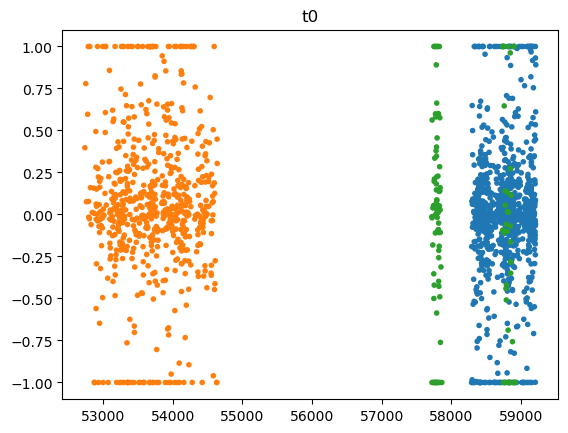

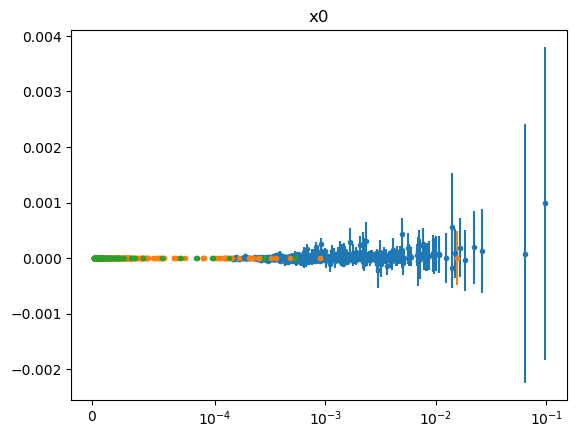

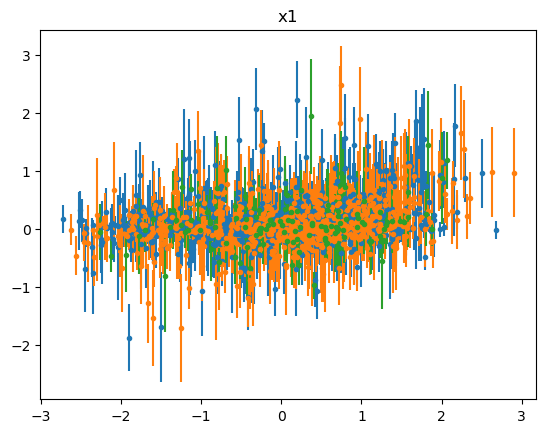

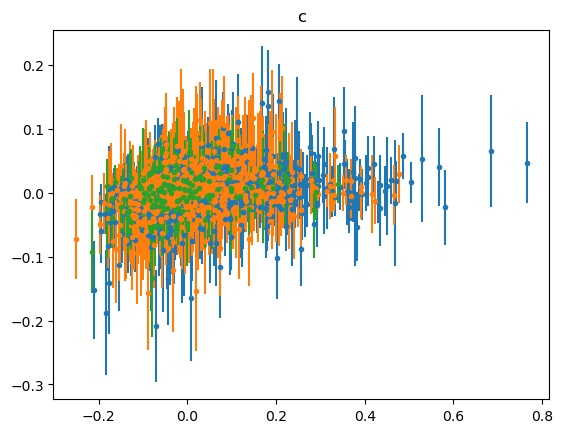

In [ ]:
plt.scatter(
    values[filt].t0,
    values[filt].t0 - valid_data[filt].t0,
    c=[survey_colors[s] for s in valid_data[filt].survey],
    marker=".",
)
plt.title("t0")
plt.figure()
for s in survey_colors.keys():
    plt.errorbar(
        values[filt & (valid_data.survey == s)].x0,
        values[filt & (valid_data.survey == s)].x0
        - valid_data[filt & (valid_data.survey == s)].x0,
        values[filt & (valid_data.survey == s)].err_x0,
        c=survey_colors[s],
        linestyle="",
        marker=".",
    )
    plt.title("x0")
    plt.semilogx()
    plt.xscale("symlog", linthresh=1e-4)

plt.figure()
for s in survey_colors.keys():

    plt.errorbar(
        values[filt & (valid_data.survey == s)].x1,
        values[filt & (valid_data.survey == s)].x1
        - valid_data[filt & (valid_data.survey == s)].x1,
        values[filt & (valid_data.survey == s)].err_x1,
        c=survey_colors[s],
        linestyle="",
        marker=".",
    )
    plt.title("x1")
plt.figure()
for s in survey_colors.keys():
    plt.errorbar(
        values[filt & (valid_data.survey == s)].c,
        values[filt & (valid_data.survey == s)].c
        - valid_data[filt & (valid_data.survey == s)].c,
        values[filt & (valid_data.survey == s)].err_c,
        c=survey_colors[s],
        linestyle="",
        marker=".",
    )
    plt.title("c")

# EDRIS

Attention, Uchuu avec Planck15, Abacus avec Planck18

In [ ]:
from astropy.cosmology import Planck15, Planck18

# cosmo = Planck15

In [1]:
from edris.cosmo import dL, Tcmb_to_Omega_gamma, Tcmb, mu

In [2]:
def flcdm(params, explanatory):
    p = {
        "Omega_m": params["Omega_m"],
        "Omega_gamma": cosmo.Ogamma0,
        "w": -1.0,
        "H0": params["H0"],
        "Omega_k": cosmo.Ok0,
    }
    return mu(p, explanatory["z"]) - 19.3

In [11]:
params = dict(
    H0=jnp.array([cosmo.H0.value]),
    Omega_m=jnp.array([cosmo.Om0]),
    Omega_gamma=jnp.array([cosmo.Ogamma0]),
    Omega_k=jnp.array([cosmo.Ok0]),
    w=jnp.array([-1.0]),
    coef=jnp.array([-0.14, 3.15]),
    sigma_int=jnp.array([jnp.array([0.1])]),
)

In [12]:
source = sncosmo.get_source("salt2", version="2.4")
model = sncosmo.Model(
    source=source,
    effects=[sncosmo.CCM89Dust()],
    effect_names=["mw"],
    effect_frames=["obs"],
)

In [13]:
with open("outdir/ztf_2M++_snls_hsc.pkl", "rb") as file:
    values = pickle.load(file)
    covs = pickle.load(file)

In [14]:
values = values[values.valid].copy()
data_ztf,_ = load_from_skysurvey('./data/dataset_2M++.pkl', survey='ZTF')
data_hsc,_ = load_from_skysurvey('./data/dataset_hsc.pkl', survey='HSC')
data_snls,_ = load_from_skysurvey('./data/dataset_snls.pkl', survey='SNLS')
data=pandas.concat([data_ztf, data_hsc, data_snls])
values = values.join(data[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi
values["rcom"] = cosmo.comoving_distance(values.z).value

In [15]:
from scipy.linalg import block_diag

full_matrix = block_diag(*[covs[i] for i in values.index])
n = len(values)
full_cov_sorted = full_matrix[
    :,
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
][
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
    :,
]

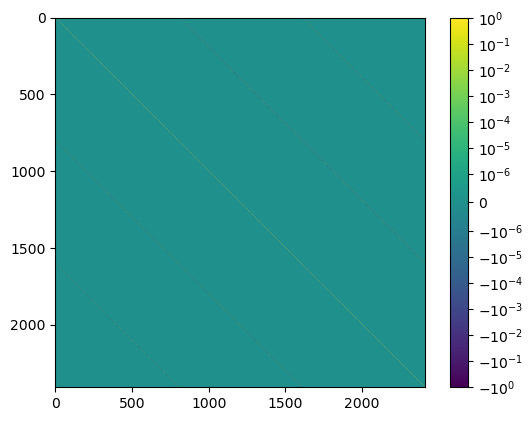

In [16]:
from matplotlib.colors import SymLogNorm

plt.imshow(
    jnp.diag(1 / jnp.sqrt(jnp.diag(full_cov_sorted)))
    @ full_cov_sorted
    @ jnp.diag(1 / jnp.sqrt(jnp.diag(full_cov_sorted))),
    norm=SymLogNorm(vmin=-1, vmax=1, linthresh=1e-6),
)
plt.colorbar()

In [18]:
values["survey"] = values.index.map(lambda s: s.split("_")[0])

/home/okc/anaconda3/envs/lemaitre/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/okc/anaconda3/envs/lemaitre/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
2025-02-24 11:51:16,708 INFO Covariance matrix generated from flip with carreres23 model in 9.69e-01 seconds
[ 000000.91 ]: 02-24 11:51  root            INFO     Covariance matrix generated from flip with carreres23 model in 9.69e-01 seconds


Text(0.5, 1.0, '$Cov_{mm}$')

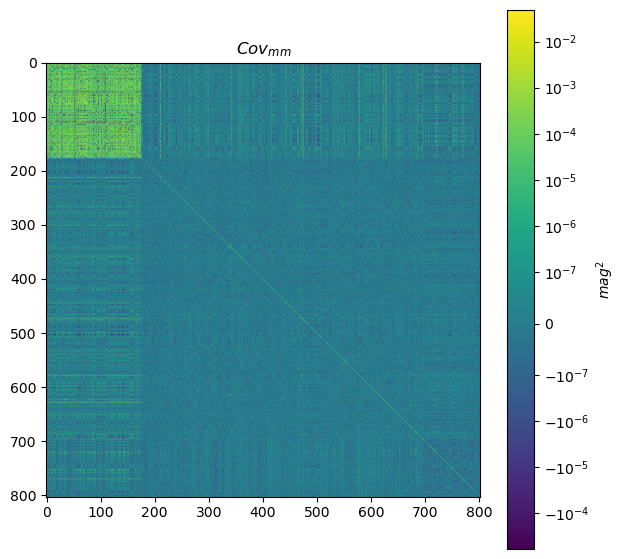

In [20]:
k, p = np.loadtxt('./data/power_spectrum.txt')

from flip import covariance, utils
coordinates = np.array([values['ra'],
                        values['dec'],
                        values['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k, p * utils.Du(k, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)

covariance_fit.compute_full_matrix()
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values.z.values]).T @ \
             np.array([1/values.z.values]))
from matplotlib.colors import SymLogNorm
plt.figure(figsize=(7,7))
plt.imshow(vpec_cov, norm=SymLogNorm(linthresh=1e-7))
plt.colorbar(label=r'$mag^2$')
plt.title(r"$Cov_{mm}$")

In [25]:
filt = (
    (values.c < 0.3) # & (values.err_x1 + np.abs(values.x1) < 5) & (values.err_c < 0.05)
)  # &\
# ((values.survey != 'ZTF') | (values.z < 0.1))
sum(filt)

780

In [26]:
surveys = set(values[filt]["survey"])
survey_map = dict(zip(surveys, range(len(surveys))))
survey_id = jnp.array([survey_map[s] for s in values[filt]["survey"]])

In [27]:
obs = Obs(
    mag=jnp.array(values[filt].magobs),
    variables=jnp.hstack([jnp.array(values[filt].x1), jnp.array(values[filt].c)]),
)

In [28]:
exp = dict(
    z=jnp.array(values[filt].z),
    survey_id=survey_id,
    survey_map=survey_map,
)

In [29]:
n = len(values)

In [42]:
cov = FullCovariance(
    full_cov_sorted[:n, :n] + vpec_cov, full_cov_sorted[n:, n:], full_cov_sorted[:n, n:]
)

In [43]:
cov = cov.select(filt.values)

In [32]:
exp["map_survey"] = {
    v: k for v, k in zip(exp["survey_map"].values(), exp["survey_map"].keys())
}

In [33]:
x0 = dict(
    H0=jnp.array([cosmo.H0.value]),
    Omega_m=jnp.array([cosmo.Om0]),
    coef=jnp.array([-0.14, 3.15]),
    variables=jnp.array(obs.variables.reshape((2, -1))),
    sigma_int=jnp.array([0.1]),
)

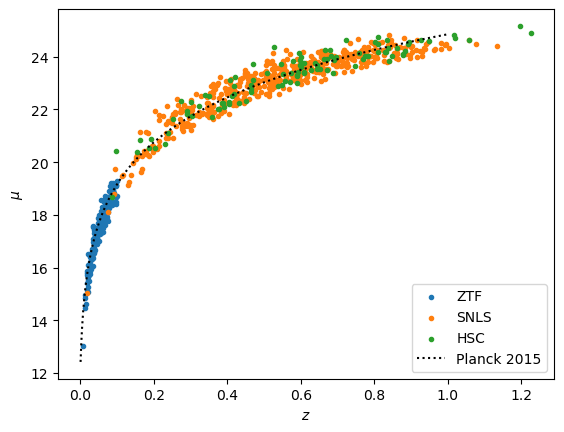

In [34]:
for survey in exp["survey_map"].keys():
    plt.scatter(
        exp["z"][exp["survey_id"] == exp["survey_map"][survey]],
        obs.mag[
            exp["survey_id"] == exp["survey_map"][survey]
        ],  # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
        c=survey_colors[survey],
        marker=".",
        label=survey,
    )

plt.plot(
    np.linspace(1e-3, 1, 1000),
    flcdm(params, {"z": jnp.linspace(5e-3, 1, 1000)}),
    linestyle=":",
    color="k",
    label="Planck 2015",
)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.legend()

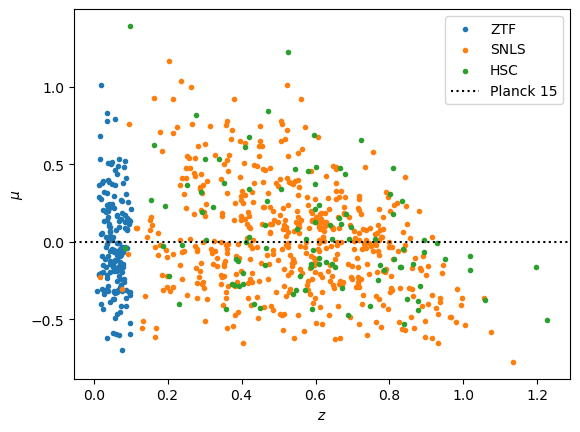

In [35]:
for survey in exp["survey_map"].keys():
    plt.scatter(
        exp["z"][exp["survey_id"] == exp["survey_map"][survey]],
        obs.mag[exp["survey_id"] == exp["survey_map"][survey]]
        - flcdm(params, {"z": exp["z"][exp["survey_id"] == exp["survey_map"][survey]]}),
        # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
        c=survey_colors[survey],
        marker=".",
        label=survey,
    )

plt.axhline(0, linestyle=":", color="k", label="Planck 15")
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.legend()

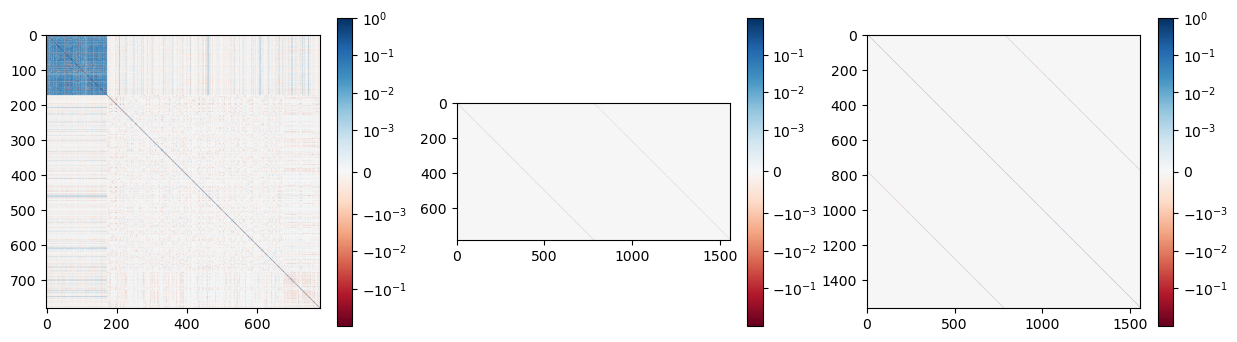

In [60]:
fig, (ax_mm, ax_mx, ax_xx) = plt.subplots(ncols = 3, figsize=(15,4))
im_mm = ax_mm.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))) @ cov.C_mm @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_mm, ax=ax_mm)
im_mx = ax_mx.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))) @ cov.C_mx @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_mx, ax=ax_mx)
im_xx = ax_xx.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))) @ cov.C_xx @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_xx, ax=ax_xx)


In [61]:
L = lambda x: likelihood(
    x, exp, cov, obs, cosmo=flcdm, truncated=False, restricted=False
)

In [62]:
L(x0)

Array(-1831.46757502, dtype=float64)

In [63]:
fit_params = dict(niter=1000, lmbda=1e4, tol=1e-3, max_iter_tncg=None, verbose=True)

In [ ]:
res, loss, lmbda, iter_params = tncg(L, x0, **fit_params)

iter 0/1000. Loss: -1.8e+03->-2.1e+03(-2.7e+02), ρ=0.66, λ=10000.0
iter 1/1000. Loss: -2.1e+03->-2.2e+03(-75), ρ=0.79, λ=3000.0
iter 2/1000. Loss: -2.2e+03->-2.3e+03(-1e+02), ρ=0.87, λ=900.0
iter 3/1000. Loss: -2.3e+03->-2.4e+03(-90), ρ=0.70, λ=900.0
iter 4/1000. Loss: -2.4e+03->-2.4e+03(-17), ρ=0.78, λ=270.0
iter 5/1000. Loss: -2.4e+03->-2.4e+03(-15), ρ=0.82, λ=81.0
iter 6/1000. Loss: -2.4e+03->-2.4e+03(-19), ρ=0.86, λ=24.3
iter 7/1000. Loss: -2.4e+03->-2.4e+03(-26), ρ=0.82, λ=7.29
iter 8/1000. Loss: -2.4e+03->-2.5e+03(-21), ρ=0.72, λ=7.29
iter 9/1000. Loss: -2.5e+03->-2.5e+03(-4.1), ρ=0.74, λ=7.29
iter 10/1000. Loss: -2.5e+03->-2.5e+03(-0.97), ρ=0.75, λ=2.187
iter 11/1000. Loss: -2.5e+03->-2.5e+03(-0.33), ρ=0.63, λ=2.187
iter 12/1000. Loss: -2.5e+03->-2.5e+03(-0.025), ρ=0.68, λ=2.187
iter 13/1000. Loss: -2.5e+03->-2.5e+03(-0.0056), ρ=0.85, λ=0.6560999999999999
iter 14/1000. Loss: -2.5e+03->-2.5e+03(-0.0098), ρ=0.90, λ=0.19682999999999998
iter 15/1000. Loss: -2.5e+03->-2.5e+03(-0.013)

In [ ]:
jax.tree.map(lambda x, y: x - y, res, x0)

{'H0': Array([0.10968479], dtype=float64),
 'Omega_m': Array([0.03842201], dtype=float64),
 'coef': Array([0.00107124, 0.08564002], dtype=float64),
 'sigma_int': Array([-0.05633393], dtype=float64),
 'variables': Array([[-3.44540599e-05,  3.91443669e-03,  1.40488349e-04,
          4.36421776e-03, -5.00069360e-05,  9.17098905e-02,
         -1.26318139e-03,  3.26441414e-05,  1.95653067e-05,
          4.51968282e-04,  6.32902602e-06, -2.42484952e-02,
          3.02684953e-06, -1.69717871e-03,  4.98088621e-05,
          3.89920433e-02,  1.92416775e-05, -9.67308297e-03,
          5.11955137e-04,  1.37461843e-02,  2.84015021e-05,
         -2.71166262e-02, -2.25066283e-03, -8.21139214e-03,
          3.69384593e-05, -2.13703202e-02,  1.02005677e-04,
          2.19013888e-02, -1.84774901e-06,  9.29679613e-04,
          6.24470110e-07, -5.33391679e-02,  1.51235227e-05,
         -3.56492440e-03,  4.65290772e-04, -2.13581083e-02,
         -1.63198571e-05,  3.25037352e-03,  7.68268878e-04,
        

In [168]:
hess = jax.hessian(L)(res)

In [ ]:
n = {k1: hess[k1][k1].shape[1] for k1 in hess.keys()}
n["variables"] *= n["coef"]
flatten_hess = jnp.vstack(
    [
        np.hstack([hess[k1][k2].reshape(n[k1], n[k2]) for k2 in hess.keys()])
        for k1 in hess.keys()
    ]
)
cov_res = jnp.linalg.inv(0.5 * flatten_hess)

In [ ]:
with open("outdir/edris_2M++_snls_hsc.pkl", "wb") as file:
    pickle.dump(obs, file)
    pickle.dump(exp, file)
    pickle.dump(cov, file)
    pickle.dump(res, file)
    pickle.dump(cov_res, file)

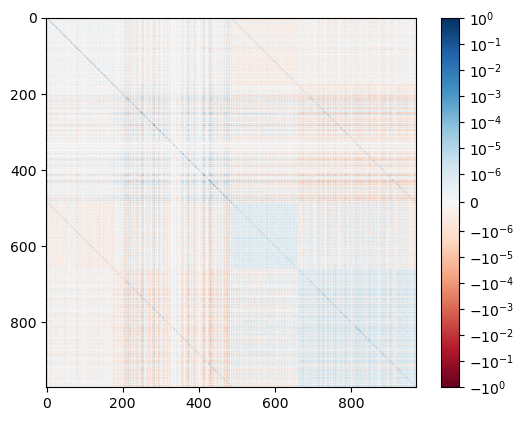

In [ ]:
from matplotlib.colors import SymLogNorm

plt.imshow(cov_res, norm=SymLogNorm(linthresh=1e-6, vmin=-1, vmax=1), cmap="RdBu")
plt.colorbar()

In [ ]:
potential_keys = ["H0", "M0", "Omega_m", "Omega_r", "Omega_l", "coef", "sigma_int"]
latex_keys = {
    "H0": "$H_0$",
    "M0": "$M_0$",
    "Omega_m": "$\\Omega_m$",
    "Omega_r": "$\\Omega_r$",
    "Omega_l": "$\\Omega_l$",
    "coef": ["$\\alpha$", "$\\beta$"],
    "sigma_int": "$\\sigma_{int}$",
    "alpha": "$\\alpha$",
    "beta": "$\\beta$",
}

In [ ]:
plt.rc("axes", labelsize=20)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=12)  # legend fontsize

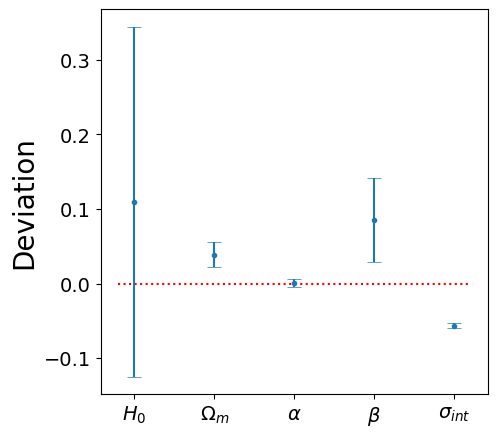

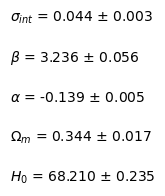

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
keys = np.array(list(res.keys()))[[p in potential_keys for p in res.keys()]]
_labels, _values, _diffs = [], [], []
for k in keys:
    _labels += latex_keys[k] if isinstance(latex_keys[k], list) else [latex_keys[k]]
    _values += list(res[k])
    _diffs += list(res[k] - x0[k])
n_pars = len(keys)
ax.hlines(0, -1, 5 * n_pars + 1, color="r", linestyle=":")
ax.set_xticks(5 * np.arange(n_pars + 1), _labels)
ax.set_ylabel("Deviation")
plt.errorbar(
    5 * np.arange(n_pars + 1),
    _diffs,
    yerr=jnp.sqrt(jnp.diag(cov_res)[: n_pars + 1]),
    linestyle="",
    marker=".",
    capsize=5,
    capthick=0.5,
)
# plt.savefig('../figures/Uchuu_final_params.png')
fig, ax = plt.subplots(figsize=(1, 1))
ax.axis("off")
for i, pos in enumerate(np.arange(n_pars + 1) * 0.4):
    fig.text(
        0,
        pos,
        _labels[i] + f" = {_values[i]:.3f} $\\pm$ {jnp.sqrt(jnp.diag(cov_res)[i]):.3f}",
    )

In [ ]:
def plot_hubble(obs, res, cov_res, cosmo, x0):
    std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
    )
    ax1.set_xscale("log")
    ax1.scatter(
        exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
    )
    ax1.plot(
        np.linspace(5e-3, 1.2, 1000),
        cosmo(x0, {"z": np.linspace(5e-3, 1.2, 1000)}),
        color="tab:green",
        linestyle=":",
        label="Underlying cosmo",
    )

    ax2.scatter(exp["z"], std_mag - cosmo(x0, exp), color="k", s=0.5, alpha=0.3)

    if "mu_bins" in res.keys():
        ax1.errorbar(
            exp["z_bins"],
            res["mu_bins"],
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
            label="edris",
        )
        ax2.errorbar(
            exp["z_bins"],
            res["mu_bins"] - cosmo(x0, {"z": exp["z_bins"]}),
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
        )
    else:
        ax1.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
            label="edris",
        )
        ax2.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)})
            - cosmo(x0, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
        )

    ax1.legend()
    ax1.set_ylabel(r"$\mu$")

    lims = ax2.get_xlim()
    ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
    ax2.set_xlim(*lims)
    ax2.set_ylabel(r"$\Delta\mu$")
    ax2.set_xlabel(r"$z$")

    fig.suptitle(r"Modèle fitté par Edris")

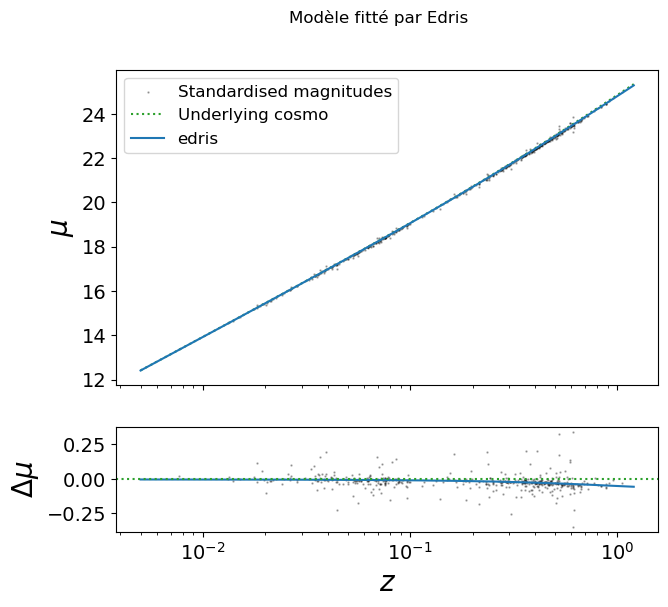

In [224]:
plot_hubble(obs, res, cov_res, flcdm, x0)

In [ ]:
mag_to_z = interp1d(
    flcdm(res, {"z": np.linspace(2e-3, 0.3, 10000)}), np.linspace(2e-3, 0.3, 10000)
)
z_cosmo_salt = mag_to_z(
    obs.mag[exp["survey_id"] == exp["survey_map"]["ZTF"]]
    - jnp.matmul(res["coef"], res["variables"])[
        exp["survey_id"] == exp["survey_map"]["ZTF"]
    ]
)

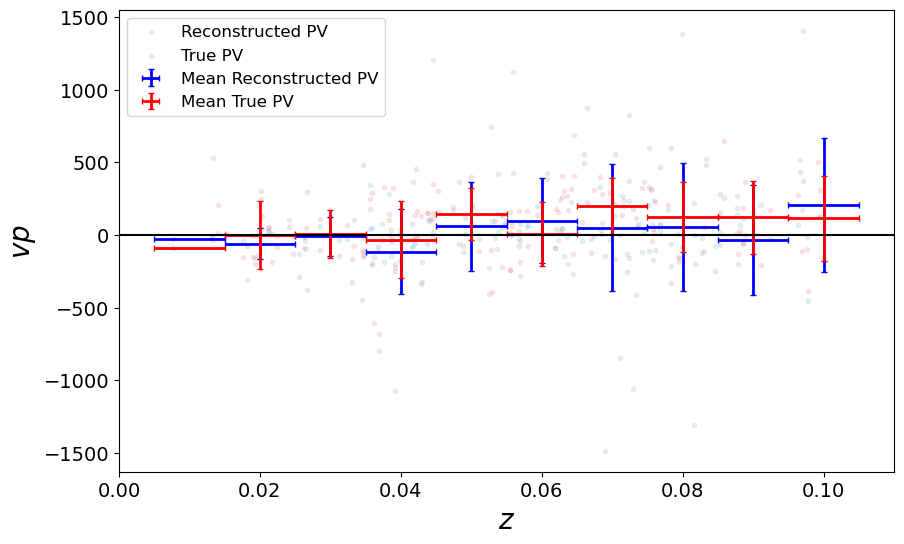

In [ ]:
data_ztf = data[data.index.isin(values[(values.survey == "ZTF") & filt].index)]
true_pv = (data_ztf.z - data_ztf.z_cosmo) * c * 1e-3 / (1 + data_ztf.z_cosmo)
edris_pv = (data_ztf.z - z_cosmo_salt) * c * 1e-3 / (1 + z_cosmo_salt)

z_max = 0.1
n_bins = 10
bounds = np.linspace(0.00, z_max, n_bins + 1)
width = z_max / n_bins
in_bins = [(data_ztf.z > z_min) & (data_ztf.z < z_min + width) for z_min in bounds]
plt.figure(figsize=(10, 6))

plt.scatter(data_ztf.z, edris_pv, marker=".", alpha=0.1, label="Reconstructed PV")
plt.scatter(
    data_ztf.z, true_pv, marker=".", color="tab:red", alpha=0.1, label="True PV"
)

plt.errorbar(
    bounds + width,
    [edris_pv[b_].mean() for b_ in in_bins],
    yerr=[edris_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="Mean Reconstructed PV",
)

plt.errorbar(
    bounds + width,
    [true_pv[b_].mean() for b_ in in_bins],
    yerr=[true_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    capsize=2,
    label="Mean True PV",
)

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color="k")

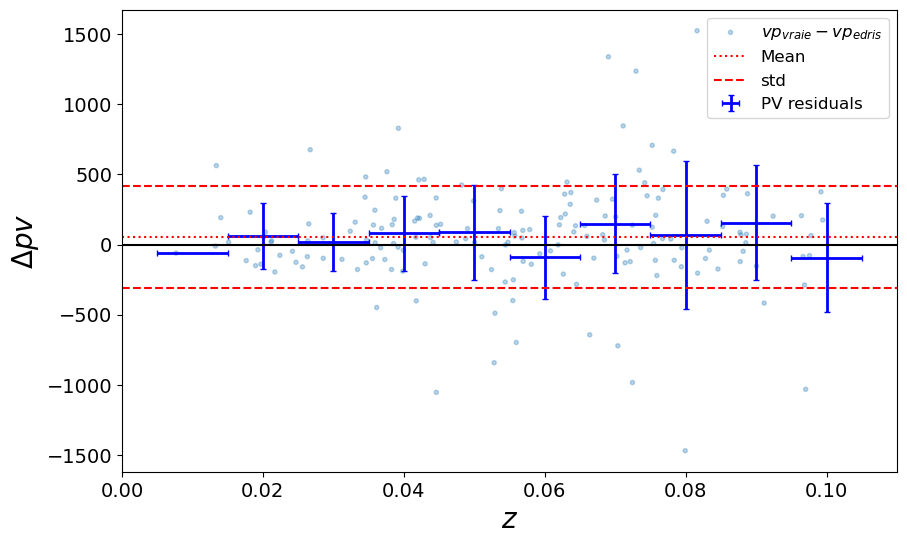

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    data_ztf.z,
    true_pv - edris_pv,
    marker=".",
    linestyle="",
    alpha=0.3,
    label="$vp_{vraie} - vp_{edris}$",
)
plt.errorbar(
    bounds + width,
    [(true_pv - edris_pv)[b_].mean() for b_ in in_bins],
    yerr=[(true_pv - edris_pv)[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="PV residuals",
)
plt.xlabel("$z$")
plt.ylabel(r"$\Delta pv$")
plt.axhline(0, color="k")
plt.axhline((true_pv - edris_pv).values.mean(), color="r", linestyle=":", label="Mean")
plt.axhline(
    (true_pv - edris_pv).values.mean() + (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
    label="std",
)
plt.axhline(
    (true_pv - edris_pv).values.mean() - (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
)

plt.legend()

In [225]:
(true_pv - edris_pv).values.mean(), (true_pv - edris_pv).values.std()

(54.5189937040982, 362.06071306406346)

# Power spectrum stuff

In [8]:
from cosmoprimo import *
cosmo_p = Cosmology(engine='camb')
cosmo_planck = fiducial.Planck2018FullFlatLCDM()

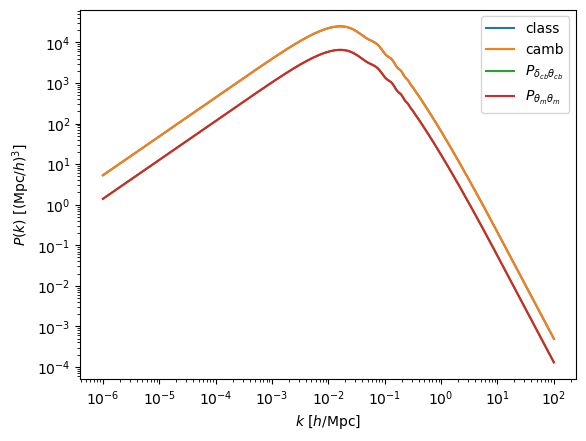

In [9]:
fo = Fourier(cosmo_p, engine='class')
pk = fo.pk_interpolator()
k = np.logspace(-6, 2, 1000)
z = 0
plt.loglog(k, pk(k, z=z), label='class')
fo_camb = cosmo_p.get_fourier(engine='camb') # second initialisation style
pk = fo_camb.pk_interpolator() # same number of cells are output than in CLASS
plt.loglog(k, pk(k, z=z), label='camb')
# cross density-velocity CDM + baryon power spectrum
plt.loglog(k,fo.pk_interpolator(of=('theta_cb', 'theta_cb'))(k, z=z), label=r'$P_{\delta_{cb}\theta_{cb}}$')
plt.loglog(k,fo.pk_interpolator(of=('theta_m', 'theta_m'))(k, z=z), label=r'$P_{\theta_{m}\theta_{m}}$')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

In [10]:
k, p = np.loadtxt('test')

In [56]:
with open("./outdir/ztf_2M++_snls_hsc_DR2cuts.pkl", "rb") as file:
    values=pickle.load(file)
    covs=pickle.load(file)

In [57]:
data_ztf,_ = load_from_skysurvey('./data/dataset_2M++.pkl', survey='ZTF')
data_hsc,_ = load_from_skysurvey('./data/dataset_hsc.pkl', survey='HSC')
data_snls,_ = load_from_skysurvey('./data/dataset_snls.pkl', survey='SNLS')
data=pandas.concat([data_ztf, data_hsc, data_snls])

In [58]:
values = values.join(data[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi

In [59]:
values["rcom"] = cosmo.comoving_distance(values.z).value
values.sort_values('z', inplace=True)

In [60]:
from flip import covariance, utils
coordinates = np.array([values['ra'],
                        values['dec'],
                        values['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k, p * utils.Du(k, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)


/home/okc/anaconda3/envs/lemaitre/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
2025-02-21 14:14:49,895 INFO Covariance matrix generated from flip with carreres23 model in 2.66e+00 seconds
[ 000239.10 ]: 02-21 14:14  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.66e+00 seconds


In [61]:
covariance_fit.compute_full_matrix()

In [63]:
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values.z.values]).T @ \
             np.array([1/values.z.values]))

Text(0.5, 1.0, '$Cov_{mm}$')

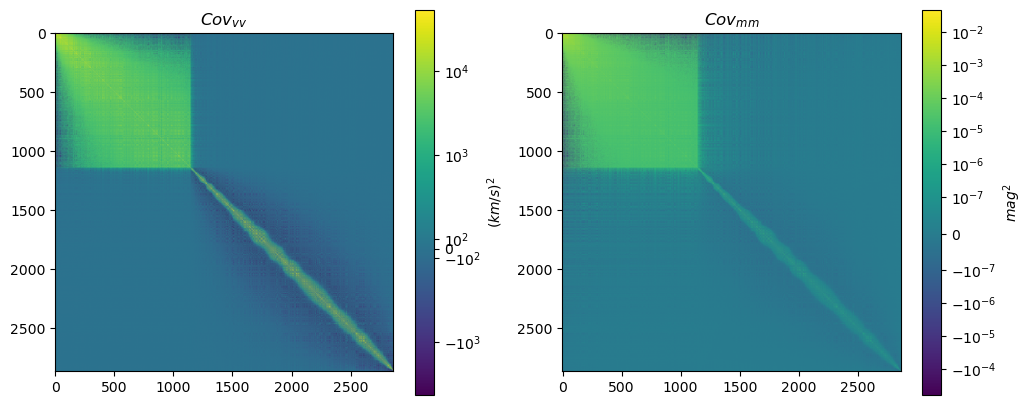

In [78]:
from matplotlib.colors import SymLogNorm
fig, (ax_vv, ax_mm) = plt.subplots(figsize=(12,5), ncols=2)
im_vv = ax_vv.imshow(covariance_fit.covariance_dict['vv'][0], norm=SymLogNorm(linthresh=1e3))
plt.colorbar(im_vv, ax=ax_vv, label=r'$(km/s)^2$')
ax_vv.set_title(r'$Cov_{vv}$')
im_mm = ax_mm.imshow(vpec_cov, norm=SymLogNorm(linthresh=1e-7))
plt.colorbar(im_mm, ax=ax_mm, label=r'$mag^2$')
ax_mm.set_title(r"$Cov_{mm}$")